# Generate multiple plots about Kr data

<i>
This notebook takes a kDST file and a correction file,
applies all corrections (including time) and makes all
kind of plots about the data.
</i>

### Notebook configuration

In [1]:
run_number          = 5846
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename        = f"$IC_DATA/RunIV/kdst_{run_number}_filtered.h5"
plots_output_folder = f"plots/{run_number}/"

Zrange              =     0, 600
XYrange             =  -200, 200
Rrange              =     0, max(XYrange)
Phirange            = -3.14, 3.14

Erange              =  33.5, 49.5
Qrange              =    50, 1500
QErange             =     0, Qrange[1] / Erange[1]

S1Erange            =     0, 40
S1Wrange            =     0, 500
S1Hrange            =     0, 10

S2Erange            =   4e3, 18e3
S2Wrange            =     0, 50
S2Hrange            =     0, 10e3
NSirange            =     0, 80

Zrange_DV           =   500, 600
Zrange_LT           =    50, 520
Zrange_XY           =     0, 520

XYnbins             =  50
Znbins              = 100
Rnbins              = 100
Phinbins            = 100
Enbins              = 200
Qnbins              = 200

S1Enbins            = 40
S1Wnbins            = 20
S1Hnbins            = 50

S2Enbins            = 100
S2Wnbins            = 50
S2Hnbins            = 80
NSinbins            = 80

DVnbins             = 50

R_fiducial          = 100
Z_fiducial          = 200

# Plotting style
default_cmap        = "jet"
figure_size         = 16, 12
font_size           = 20
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

save_plots          = True
with_titles         = False
plots_format        = "pdf"

### Imports

In [2]:
import os
import time
import collections
import itertools
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db        as DB
import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .corrections    as corrf
import invisible_cities.reco    .dst_functions  as dstf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import hist2d
from invisible_cities.icaro. hst_functions import pdf
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer
from invisible_cities.icaro. hst_functions import measurement_string

from icaro.core.fit_functions import conditional_labels

Running on  Fri Jun 15 17:40:36 2018


### Initialization

In [3]:
save   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None
labels = conditional_labels(with_titles)

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] = figure_size
plt.rcParams[  "font.size"            ] =   font_size
plt.rcParams["figure.max_open_warning"] = 1000

In [5]:
Zbins     = np.linspace(*  Zrange   ,   Znbins + 1)
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)
Qbins     = np.linspace(*  Qrange   ,   Qnbins + 1)

S1Ebins   = np.linspace(*S1Erange   , S1Enbins + 1)
S1Wbins   = np.linspace(*S1Wrange   , S1Wnbins + 1)
S1Hbins   = np.linspace(*S1Hrange   , S1Hnbins + 1)

S2Ebins   = np.linspace(*S2Erange   , S2Enbins + 1)
S2Wbins   = np.linspace(*S2Wrange   , S2Wnbins + 1)
S2Hbins   = np.linspace(*S2Hrange   , S2Hnbins + 1)
NSibins   = np.linspace(*NSirange   , NSinbins + 1)

XYbins    = np.linspace(* XYrange   ,  XYnbins + 1)
Rbins     = np.linspace(*  Rrange   ,   Rnbins + 1)
Phibins   = np.linspace(*Phirange   , Phinbins + 1)
DVbins    = np.linspace(*  Zrange_DV,  DVnbins + 1)

dst_filename        = os.path.expandvars(       dst_filename)
correction_filename = os.path.expandvars(correction_filename)

### Read data

In [6]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst))
dst.head()

OSError: ``/Users/Gonzalo/github/NEXTdata//RunIV/kdst_5846_filtered.h5`` does not exist

In [7]:
ELT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Elifetime")

QLT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Qlifetime")

EGEO_correction = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          =  "Egeometry",
                                           norm_strategy =  "index",
                                           norm_opts     = {"index": (40, 40)})

QGEO_correction = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          =  "Qgeometry",
                                           norm_strategy =  "index",
                                           norm_opts     = {"index": (40, 40)})

NoSuchNodeError: group ``/XYcorrections`` does not have a child named ``Elifetime``

In [8]:
evt = dst.event.values
T   =(dst.time .values -
      dst.time .values.min()) / 60
S2n = dst.nS2  .values

S1e = dst.S1e.values
S1w = dst.S1w.values
S1h = dst.S1h.values
S1t = dst.S1t.values

S2e = dst.S2e.values
S2w = dst.S2w.values
S2h = dst.S2h.values
S2t = dst.S2t.values
S2q = dst.S2q.values

X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values
Phi = dst.Phi  .values
Nsi = dst.Nsipm.values

E   = S2e * ELT_correction(Z, X, Y).value * EGEO_correction(X, Y).value
Q   = S2q * QLT_correction(Z, X, Y).value * QGEO_correction(X, Y).value

NameError: name 'dst' is not defined

In [9]:
t, e, eu = fitf.profileX(T, E, 100)
hist2d(T, E, (np.linspace(0, T.max(), 50), S2Ebins), cmin=1)
plt.errorbar(t, e, eu, fmt="kp")
plt.colorbar().set_label("# events")
labels("Time (min)", "Energy (pes)")
save("ChargeUp")

NameError: name 'T' is not defined

In [10]:
t, e, eu = fitf.profileX(T, E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": 41.5})

t, q, qu = fitf.profileX(T, Q, 100)
QT_correction = corrf.Correction((t,), q, qu,
                                 norm_strategy =  "max")

E = E * ET_correction(T).value
Q = Q * QT_correction(T).value

NameError: name 'T' is not defined

##### Input maps

In [11]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Elifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, LT,
                        vmin = np.nanpercentile(LT.flatten(),  1.0),
                        vmax = np.nanpercentile(LT.flatten(), 99.2),
                        cmap = default_cmap)
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime map")
save("Lifetime_map")

*_, cb = display_matrix(x, y, LTu,
                        vmin = 1e-3,
                        vmax = np.mean(LTu) + np.std(LTu),
                        cmap = default_cmap)

cb.set_label("Lifetime unceratinty (µs)")
labels("X (mm)", "Y (mm)", "Lifetime uncertainty map")
save("Lifetime_uncertainty_map")

NoSuchNodeError: group ``/XYcorrections`` does not have a child named ``Elifetime``

In [12]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Qlifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, LT,
                        vmin = np.mean(LT) - 2.5 * np.std(LT),
                        vmax = np.mean(LT) + 2.5 * np.std(LT),
                        cmap = default_cmap)
cb.set_label("Charge lifetime (µs)")
labels("X (mm)", "Y (mm)", "Charge lifetime map")
save("Charge_lifetime_map")

*_, cb = display_matrix(x, y, LTu,
                        vmin = 1e-3,
                        vmax = np.mean(LTu) + np.std(LTu),
                        cmap = default_cmap)

cb.set_label("Charge lifetime unceratinty (µs)")
labels("X (mm)", "Y (mm)", "Charge lifetime uncertainty map")
save("Charge_lifetime_uncertainty_map")

NoSuchNodeError: group ``/XYcorrections`` does not have a child named ``Qlifetime``

In [13]:
GEOmap = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = "Egeometry")

x  = np.unique(GEOmap.x.values)
y  = np.unique(GEOmap.y.values)
f  = GEOmap.factor     .values.reshape(x.size, y.size)
fu = GEOmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, f,
                        cmap = default_cmap)
cb.set_label("Energy(pes)")
labels("X (mm)", "Y (mm)", "Geometry map")
save("Energy_map")

*_, cb = display_matrix(x, y, fu,
                        vmax = np.mean(fu) + 3 * np.std(fu),
                        cmap = default_cmap)
cb.set_label("Energy unceratinty (pes)")
labels("X (mm)", "Y (mm)", "Geometry uncertainty map")
save("Energy_uncertainty_map")

ValueError: zero-size array to reduction operation maximum which has no identity

In [14]:
GEOmap = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = "Qgeometry")

x  = np.unique(GEOmap.x.values)
y  = np.unique(GEOmap.y.values)
f  = GEOmap.factor     .values.reshape(x.size, y.size)
fu = GEOmap.uncertainty.values.reshape(x.size, y.size)

*_, cb = display_matrix(x, y, f,
                        vmin = Qrange[0],
                        vmax = Qrange[1],
                        cmap = default_cmap)
cb.set_label("Charge(pes)")
labels("X (mm)", "Y (mm)", "Charge map")
save("Charge_map")

*_, cb = display_matrix(x, y, fu,
                        vmax = np.mean(fu) + 3 * np.std(fu),
                        cmap = default_cmap)
cb.set_label("Charge unceratinty (pes)")
labels("X (mm)", "Y (mm)", "Charge uncertainty map")
save("Charge_uncertainty_map")

NoSuchNodeError: group ``/XYcorrections`` does not have a child named ``Qgeometry``

##### Number of S2s

In [15]:
hist(S2n, 5, (0, 5))
plt.yscale("log")
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

NameError: name 'S2n' is not defined

##### Z distribution

In [16]:
hist(Z, Zbins)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

NameError: name 'Z' is not defined

##### Trigger rate

In [17]:
y, x, _ = hist(T, 100, (0, np.max(T)))
dt      = np.diff(x)[0]

labels( "Time (min)",
       f"Event rate (({dt:.2f} min)$^{{-1}}$)",
        "Trigger rate")
save("EventRate")

NameError: name 'T' is not defined

##### Raw spectrum

In [18]:
pdf(S2e, S2Ebins)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy_wide")

hist(S2e, S2Ebins)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy")

NameError: name 'S2e' is not defined

##### Drift velocity

In [19]:
y, x, _  = hist(Z, DVbins)

sigmoid  = lambda x, A, B, C, D: A / (1 + np.exp((x - B) / C)) + D
seed     = np.max(y), np.mean(Zrange_DV), np.diff(Zrange_DV)[0] / 100, np.min(y)
f        = fitf.fit(sigmoid, x, y, seed, sigma=poisson_sigma(y))

z_cathode = DB.DetectorGeo().ZMAX[0]
dv        = z_cathode / f.values[1]
u_dv      =        dv / f.values[1] * f.errors[1]

plt.plot(x, f.fn(x), lw=global_linewidth, c=global_linecolor)
labels("Drift time ($\mu$s)", "Entries", "Z distribution around cathode")

print("Max drift length = {:.3f} +- {:.3f}".format(f.values[1], f.errors[1]))
print("Drift velocity   = {:.5f} +- {:.5f}".format(dv, u_dv))
save("Drift_velocity")

NameError: name 'Z' is not defined

##### S1 distributions

In [20]:
hist(S1e, S1Ebins)
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

hist2d(Z, S1e, (Zbins, S1Ebins))
labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy vs Z")
save("S1energyZ")

NameError: name 'S1e' is not defined

In [21]:
short_drift = coref.in_range(  Z, 0, Z_fiducial) &\
              coref.in_range(S1e, *S1Erange)

x, y, S, u_S = fitf.profileXY(X  [short_drift],
                              Y  [short_drift],
                              S1e[short_drift],
                              XYnbins, XYnbins,
                              XYrange, XYrange)
_, cb = display_matrix(x, y, S)
cb.set_label("S1 energy (pes)")
labels("x (mm)", "y (mm)", "S1 energy vs XY")
save("S1energyXY")

NameError: name 'Z' is not defined

In [22]:
hist(S1w, S1Wbins)
labels("S1 width (ns)", "Entries", "S1 width")
save("S1width")

hist2d(Z, S1w, (Zbins, S1Wbins))
labels("Drift time ($\mu$s)", "S1 width (ns)", "S1 width vs Z")
save("S1widthZ")

NameError: name 'S1w' is not defined

In [23]:
hist(S1h, S1Hbins)
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

hist2d(Z, S1h, (Zbins, S1Hbins))
labels("Drift time ($\mu$s)", "S1 height (pes)", "S1 height vs Z")
save("S1heightZ")

NameError: name 'S1h' is not defined

In [24]:
S1r   = S1h / S1e
_bins = np.linspace(0, np.max(S1r), 50)

hist(S1r, _bins)
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

hist2d(Z, S1r, (Zbins, _bins))
labels("Drift time ($\mu$s)", "Height/Area", "S1 peak to area ratio vs Z")
save("S1Peak2AreaZ")

NameError: name 'S1h' is not defined

##### S2 distributions

In [25]:
hist(S2e, S2Ebins)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(Z, S2e, (Zbins, S2Ebins))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyZ")

NameError: name 'S2e' is not defined

In [26]:
hist(S2w, S2Wbins)
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

hist2d(Z, S2w, (Zbins, S2Wbins))
labels("Drift time ($\mu$s)", "S2 width (µs)", "S2 width vs Z")
save("S2widthZ")

NameError: name 'S2w' is not defined

In [27]:
hist(S2h, S2Hbins)
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

hist2d(Z, S2h, (Zbins, S2Hbins))
labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightZ")

NameError: name 'S2h' is not defined

In [28]:
S2r   = S2h / S2e
_bins = np.linspace(0, np.max(S2r), 100)


hist(S2r, _bins)
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

hist2d(Z, S2r, (Zbins, _bins))
labels("Drift time ($\mu$s)", "Height/Area", "S2 peak to area ratio vs Z")
save("S2Peak2AreaZ")

NameError: name 'S2h' is not defined

# S2 vs S1

In [29]:
hist2d(S1e, S2e, (S1Ebins, S2Ebins))
labels("S1 energy (pes)", "S2 energy (pes)", "S2 vs S1")
save("S2S1")

NameError: name 'S1e' is not defined

In [30]:
S12r  = S1e / S2e
_bins = np.linspace(0, np.mean(S12r) + 3 * np.std(S12r), 100)

hist(S12r, _bins)
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

hist2d(Z, S12r, (Zbins, _bins))
labels("Drift time ($\mu$s)", "S1/S2", "S1/S2 ratio vs Z")
save("S12ratioZ")

NameError: name 'S1e' is not defined

##### Tracking

In [31]:
hist(Nsi, NSibins)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(Z, Nsi, (Zbins, NSibins))
labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmZ")

NameError: name 'Nsi' is not defined

In [32]:
hist(X, XYbins)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Y, XYbins)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(R, Rbins)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Phi, Phibins)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(R, Phi, (Rbins, Phibins))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

NameError: name 'X' is not defined

In [33]:
hist(S2q, Qbins)
labels("S2 charge (pes)", "Entries", "Charge")
save("Q")

hist2d(Z, S2q, (Zbins, Qbins))
labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QZ")

NameError: name 'S2q' is not defined

In [34]:
sel = Z < 100
x = X[sel]
y = Y[sel]
q = Q[sel]
x, y, z, _ = fitf.profileXY(x, y, q, 50, 50)
display_matrix(x, y, z);

NameError: name 'Z' is not defined

In [35]:
sel = Z < 100
hist2d(X[sel], Y[sel], (np.linspace(-200, 200, 50), np.linspace(-200, 200, 50)));

NameError: name 'Z' is not defined

In [36]:
x, y, q, u_q = \
fitf.profileXY(X, Y, S2q,
               XYnbins, XYnbins,
               XYrange, XYrange)
_, cb = display_matrix(x, y, q, vmin=np.min(q[q > 0]),
                       cmap = default_cmap)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QXY")

x, y, q, u_q = \
fitf.profileXY(R, Phi, S2q,
               Rnbins, Phinbins,
               Rrange, Phirange)
_, cb = display_matrix(x, y, q, vmin=np.min(q[q > 0]),
                       cmap = default_cmap)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(R, S2q, (Rbins, Qbins))
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Phi, S2q, (Phibins, Qbins))
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

NameError: name 'X' is not defined

##### Energy dependence

In [37]:
x, y, e, eu = \
fitf.profileXY(X, Y, E, XYnbins, XYnbins, XYrange, XYrange)
_, cb = display_matrix(x, y, e, vmin=np.min(e[e > 0]),
                       cmap = default_cmap)
cb.set_label("Energy (keV)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EnergyXY")

r, phi, e, eu = \
fitf.profileXY(R, Phi, E, Rnbins, Phinbins, Rrange, Phirange)
_, cb = display_matrix(r, phi, e, vmin=np.min(e[e > 0]),
                       cmap = default_cmap)
cb.set_label("Energy (keV)")
labels("r (mm)", "$\phi$ (rad)", "Energy vs R$\phi$")
save("EnergyRPhi")

hist2d(Z, E, (Zbins, Ebins))
labels("Drift time (µs)", "SEnergy (keV)")
save("EnergyZ")

hist2d(R, E, (Rbins, Ebins))
labels("R (mm)", "Energy (keV)")
save("EnergyR")

hist2d(Phi, E, (Phibins, Ebins))
labels("$\phi$ (rad)", "Energy (keV)")
save("EnergyPhi")

hist2d(T, E, (np.linspace(0, T.max(), 100), Ebins))
labels("Time (min)", "Energy (keV)", "Energy vs Time")
save("EnergyTime")

NameError: name 'X' is not defined

### Charge dependence

In [38]:
x, y, q, qu = \
fitf.profileXY(X, Y, Q, XYnbins, XYnbins, XYrange, XYrange)
_, cb = display_matrix(x, y, q, vmin=np.min(q[q > 0]),
                       cmap = default_cmap)
cb.set_label("Charge (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("ChargeXY")

r, phi, q, qu = \
fitf.profileXY(R, Phi, Q, Rnbins, Phinbins, Rrange, Phirange)
_, cb = display_matrix(r, phi, q, vmin=np.min(q[q > 0]),
                       cmap = default_cmap)
cb.set_label("Charge (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("ChargeRPhi")

hist2d(Z, Q, (Zbins, Qbins))
labels("Drift time (µs)", "Charge (keV)")
save("ChargeZ")

hist2d(R, Q, (Rbins, Qbins))
labels("R (mm)", "Charge (keV)")
save("ChargeR")

hist2d(Phi, Q, (Phibins, Qbins))
labels("$\phi$ (rad)", "Charge (keV)")
save("ChargePhi")

hist2d(T, Q, (np.linspace(0, T.max(), 100), Qbins))
labels("Time (min)", "Charge (pes)", "Charge vs Time")
save("ChargeTime")

NameError: name 'X' is not defined

##### Charge/Energy ratio

In [39]:
QEratio = Q / E
QEratio = np.where(np.isfinite(QEratio), QEratio, 0)

QEbins = np.linspace(np.mean(QEratio) - 5 * np.std(QEratio),
                     np.mean(QEratio) + 5 * np.std(QEratio), 100)
hist(QEratio, QEbins)
labels("Q/E (pes/keV)", "Entries")
save("QEratio")

hist2d(Z, QEratio, (Zbins, QEbins))
labels("Drift time (µs)", "Q/E (pes/keV)", "Charge/Energy ratio vs Z")
save("QEratioZ")

x, y, qe, qeu = \
fitf.profileXY(X, Y, QEratio, XYnbins, XYnbins, XYrange, XYrange)
_, cb = display_matrix(x, y, qe,
                       cmap = default_cmap)
cb.set_label("Q/E (pes/keV)")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QEratioXY")

NameError: name 'Q' is not defined

##### Energy resolution

In [40]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, bkg=fitf.gauss, n_sigma=3.5, n_trials=10, **kwargs):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    gauss_seed    = (    Npeak,     Epeak,  Speak)
    gauss_lbounds = (        0,         0,      0)
    gauss_ubounds = (10*E.size, np.max(E), np.inf)
    if   bkg is None:
        bkg_seed    = ()
        bkg_lbounds = ()
        bkg_ubounds = ()
        bkg         = lambda *x: -1
    elif bkg is fitf.gauss:
        bkg_seed    = (Npeak*2,   Epeak, Speak*50)
        bkg_lbounds = (      0,       0,        0)
        bkg_ubounds = (+np.inf, +np.inf,  +np.inf)
    elif bkg is fitf.polynom:
        degree = kwargs.get("degree", 2)

        if   degree == 0:
            bkg_seed    = (  1,)
            bkg_lbounds = (  0,)
            bkg_ubounds = (1e3,)
        elif degree == 1:
            bkg_seed    = (      1,       1)
            bkg_lbounds = (-np.inf, -np.inf)
            bkg_ubounds = (+np.inf, +np.inf)
        elif degree == 2:
            bkg_seed    = (     -1,       1,       1)
            bkg_lbounds = (-np.inf, -np.inf, -np.inf)
            bkg_ubounds = (      0, +np.inf, +np.inf)
        else:
            raise ValueError("degree {} not supported".format(degree))

    else:
        raise ValueError("bkg type {} is not supported".format(getattr(bkg, "__name__", bkg)))
            
    seed    = (*gauss_seed   , *bkg_seed   )
    lbounds = (*gauss_lbounds, *bkg_lbounds)
    ubounds = (*gauss_ubounds, *bkg_ubounds)
    for i in itertools.count():
        try:
            seed = np.random.normal(seed, np.abs(seed) * 0.2)
            seed = np.clip(seed, lbounds, ubounds)
            fit_range = (Epeak - n_sigma * Speak,
                         Epeak + n_sigma * Speak)
            f    = fitf.fit(fun, x, y, seed,
                            fit_range = fit_range,
                            sigma     = yu,
                            bounds    = (lbounds, ubounds),
                            maxfev    = 10000)

            assert not np.any(np.isclose(f.values, seed)), f.values
            assert f.chi2 < 50

            R   = resolution(f.values, f.errors, 41.5)
            sel = coref.in_range(x, *fit_range)
            ry  = (f.fn(x) - y) / yu
            return reso_fit_data(xy_data(x, y, xu, yu),
                                 xy_data(x[sel], ry[sel], xu, yu[sel]),
                                 f, R)
        except (AssertionError, RuntimeError) as e:
            print(f"Failed {i}")
            if i < n_trials: continue
            raise e

In [41]:
bkg  = fitf.polynom
data = measure_resolution(E, bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn   (x)                   , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", "Energy spectrum")
save("EnergySpectrum")

NameError: name 'E' is not defined

NameError: name 'data' is not defined

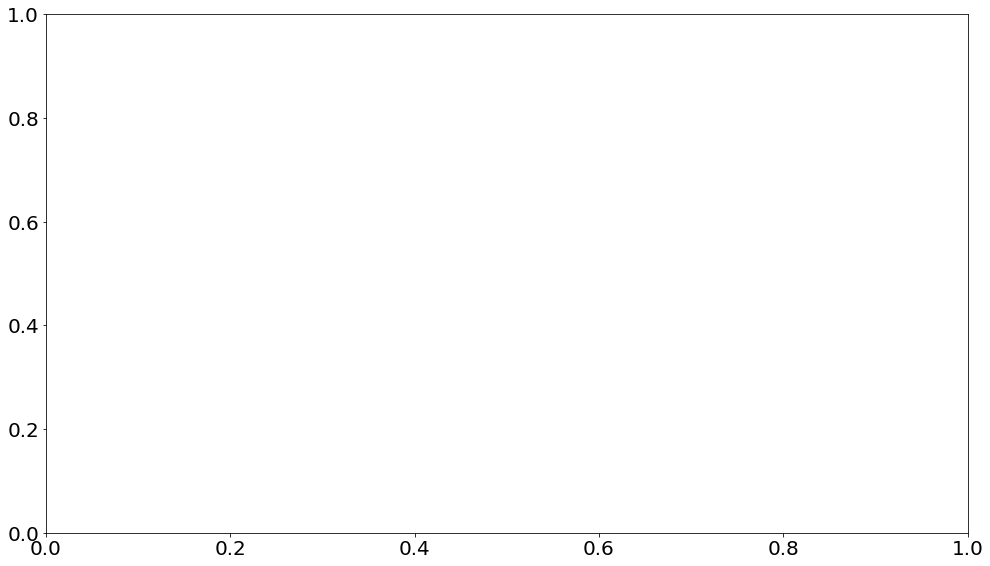

In [42]:
frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
frame_data.set_xticklabels([])
plt.ylabel("Entries")
plt.ylim(0)
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(data.residuals.x, data.residuals.y, 1, data.residuals.xu, fmt="p", c="k")
plt.plot    (lims, [0,0], "g--")
plt.xlim(*lims)
labels("E (keV)", "Standarized residual")
save("EnergySpectrumCool")

##### Energy resolution best case

In [43]:
sel_r = coref.in_range(R, 0, R_fiducial)
bkg   = fitf.polynom
data  = measure_resolution(E[sel_r], bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])

plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for R < {R_fiducial:.0f} mm")
save("EnergySpectrumFiducialR")

NameError: name 'R' is not defined

In [44]:
sel_z = coref.in_range(Z, 0, Z_fiducial)
bkg   = fitf.polynom
data  = measure_resolution(E[sel_z], bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x, bkg       (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for Z < {Z_fiducial:.0f} µs")
save("EnergySpectrumFiducialZ")

NameError: name 'Z' is not defined

In [45]:
sel_r = coref.in_range(R, 0, R_fiducial)
sel_z = coref.in_range(Z, 0, Z_fiducial)
bkg   = fitf.polynom
data  = measure_resolution(E[sel_r & sel_z], bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   )
plt.plot        (x, fitf.gauss(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
plt.plot        (x,bkg        (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
plt.fill_between(x,bkg        (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for R < {R_fiducial:.0f} mm, Z < {Z_fiducial:.0f} µs")
save("EnergySpectrumFiducialRZ")

NameError: name 'R' is not defined

##### Energy resolution dependence

In [46]:
rbins = np.linspace(*Rrange, 17)
nbins = len(rbins) - 1
r     = shift_to_bin_centers(rbins)
dr    = 0.5 * np.diff       (rbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_z = coref.in_range(Z, 0, Z_fiducial)
for i in range(nbins):
    plt.subplot(4, 4, i+1)
    try:
        rmin, rmax = rbins[i:i+2]
        sel_r = coref.in_range(R, rmin, rmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E[sel], bkg=fitf.polynom)

        print(f"R in [{rmin:.1f}, {rmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"R $\in$ [{rmin:.1f}, {rmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionRslices")

NameError: name 'Z' is not defined

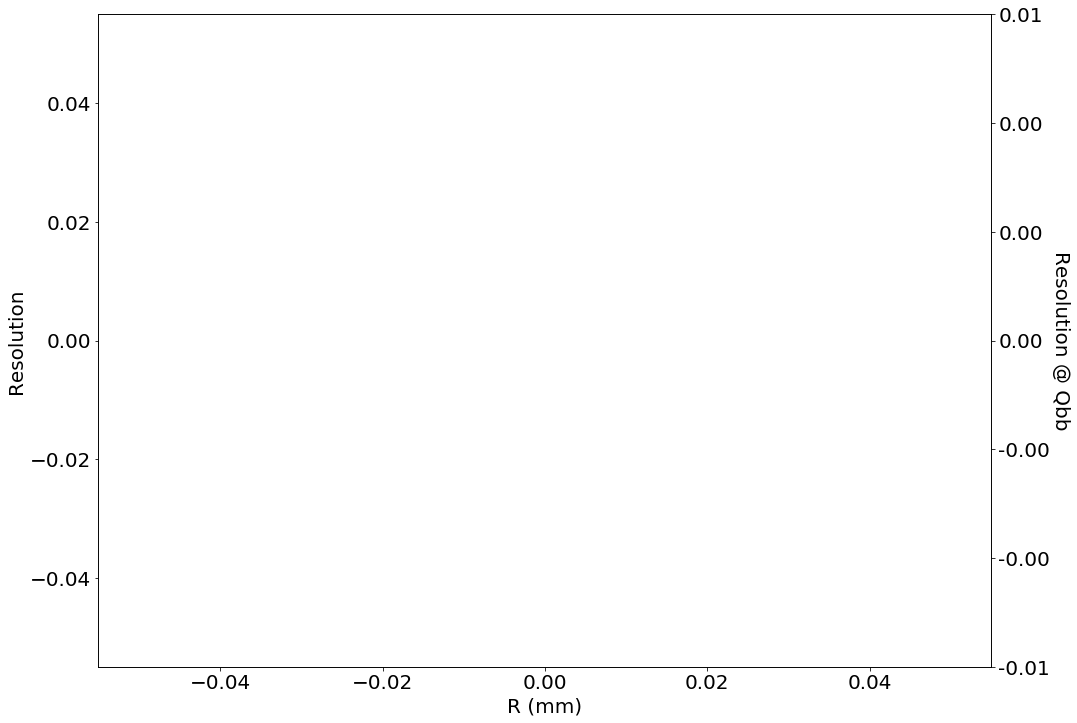

In [47]:
plt.errorbar(r[valid], Resolution[valid], Resolutionu[valid], dr[valid], "kp")
labels("R (mm)", "Resolution", "Resolution vs R")

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionR")

In [48]:
zbins = np.linspace(*Zrange, 13)
nbins = len(zbins) - 1
z     = shift_to_bin_centers(zbins)
dz    = 0.5 * np.diff       (zbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_r = coref.in_range(R, 0, R_fiducial)
for i in range(nbins):
    plt.subplot(3, 4, i+1)
    try:
        zmin, zmax = zbins[i:i+2]
        sel_z = coref.in_range(Z, zmin, zmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E[sel], bkg=fitf.polynom)

        print(f"Z in [{zmin:.1f}, {zmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionZslices")

NameError: name 'R' is not defined

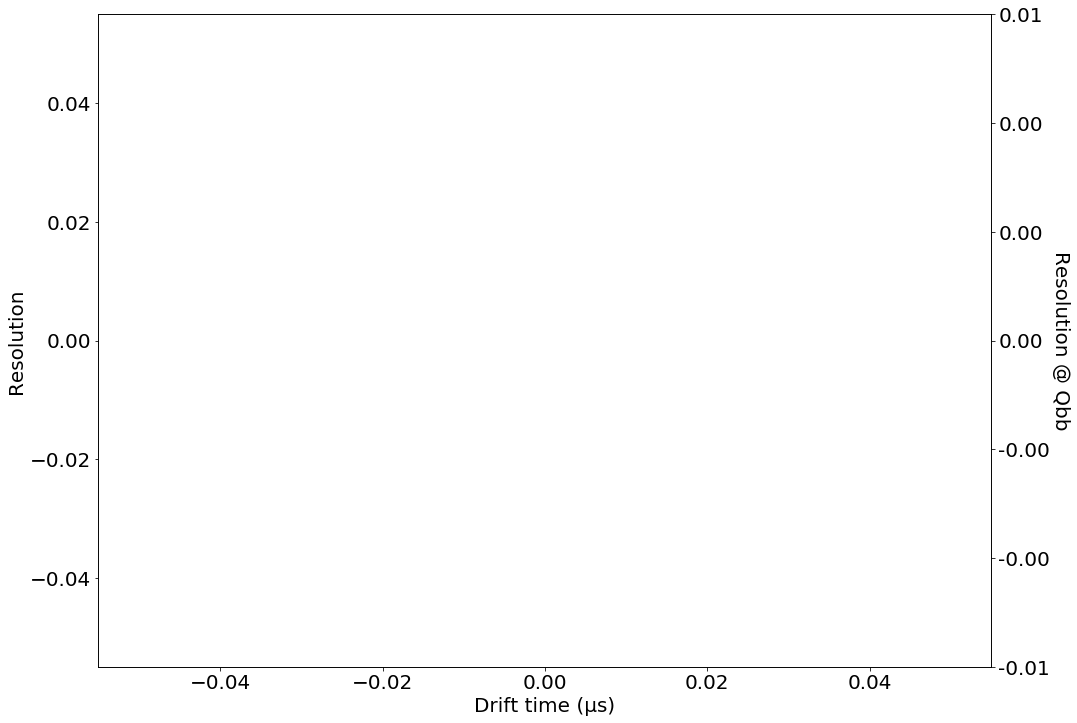

In [49]:
plt.errorbar(z[valid], Resolution[valid], Resolutionu[valid], dz[valid], "kp")
labels("Drift time (µs)", "Resolution", "Resolution vs Z")

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionZ")

In [50]:
tbins = np.linspace(0, T.max(), 6)
nbins = len(tbins) - 1
t     = shift_to_bin_centers(tbins)
dt    = 0.5 * np.diff       (tbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_rz = coref.in_range(R, 0, R_fiducial) & coref.in_range(Z, 0, Z_fiducial)
for i in range(nbins):
    plt.subplot(4, 4, i+1)
    try:
        tmin, tmax = tbins[i:i+2]
        sel_t = coref.in_range(T, tmin, tmax)
        sel   = sel_t & sel_rz
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E[sel], bkg=fitf.polynom)

        print(f"T in [{tmin:.1f}, {tmax:.1f}) min")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"R $\in$ [{rmin:.1f}, {rmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionTslices")

NameError: name 'T' is not defined

In [51]:
plt.errorbar(t[valid], Resolution[valid], Resolutionu[valid], dt[valid], "kp")
labels("Time (min)", "Resolution", "Resolution vs T")

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionT")

NameError: name 't' is not defined

In [52]:
xybins = np.linspace(*XYrange, 16)
nbins  = len(xybins) - 1
xy     = shift_to_bin_centers(xybins)
dxy    = 0.5 * np.diff       (xybins)

valid         = np.zeros((nbins, nbins), dtype=bool     )
Chi2          = np.zeros((nbins, nbins), dtype=np.double)
Resolution    = np.zeros((nbins, nbins), dtype=np.double)
Resolutionu   = np.zeros((nbins, nbins), dtype=np.double)
ResolutionBB  = np.zeros((nbins, nbins), dtype=np.double)
ResolutionBBu = np.zeros((nbins, nbins), dtype=np.double)

plt.figure(figsize=(30, 30))

sel_z = coref.in_range(Z, 0, Z_fiducial)
for i in range(nbins):
    for j in range(nbins):
        plt.subplot(nbins, nbins, i * nbins + j + 1)

        xmin, xmax = xybins[i : i + 2]
        ymin, ymax = xybins[j : j + 2]
        sel_x = coref.in_range(X, xmin, xmax)
        sel_y = coref.in_range(Y, ymin, ymax)

        try:
            data  = measure_resolution(E[sel_x & sel_y & sel_z], bkg=fitf.polynom)

            x = data.xy.x
            plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
            plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
            plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
            plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

            plt.ylim(0)
            labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

            Resolution  [i, j], Resolutionu  [i, j] = data.R[0]
            ResolutionBB[i, j], ResolutionBBu[i, j] = data.R[1]
            Chi2        [i, j]                      = data.f.chi2
            valid       [i, j]                      = True
        except:
            pass

plt.tight_layout()
save("ResolutionXYbins")

NameError: name 'Z' is not defined

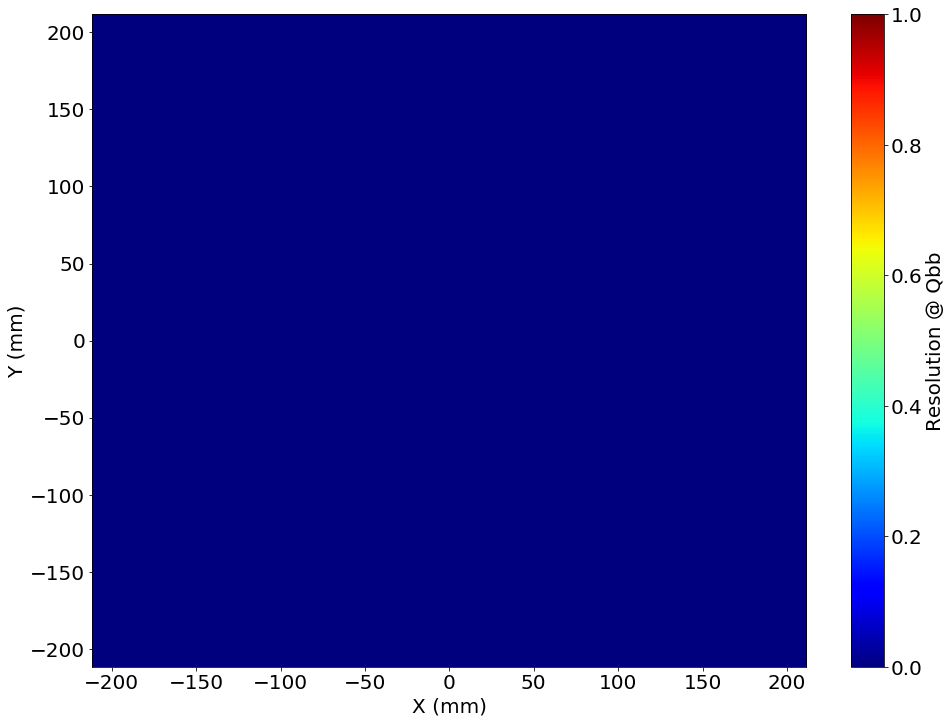

In [53]:
*_, cb = display_matrix(xy, xy, ResolutionBB, vmin = 0, vmax = 1,
                        cmap = default_cmap)
cb.set_label("Resolution @ Qbb")
labels("X (mm)", "Y (mm)", "Resolution vs XY")
save("ResolutionXY")

In [54]:
tbins = np.linspace(0, T.max(), 10)
nbins = len(tbins) - 1
t     = shift_to_bin_centers(tbins)
dt    = 0.5 * np.diff       (tbins)

valid_top     = np.zeros(nbins, dtype=bool     )
Chi2_top      = np.zeros(nbins, dtype=np.double)
lifetime_top  = np.zeros(nbins, dtype=np.double)
lifetimeu_top = np.zeros(nbins, dtype=np.double)

sel_xy = coref.in_range(X, -10, 10) & coref.in_range(Y, 90, 110)
ee = S2e * EGEO_correction(X, Y).value # * ELT_correction(Z, X, Y).value
for i in range(nbins):
    plt.subplot(3, 3, i+1)
    try:
        tmin, tmax = tbins[i:i+2]
        sel_t = coref.in_range(T, tmin, tmax)
        sel   = sel_t & sel_xy
        if np.count_nonzero(sel) < 100: continue

        z, e = Z[sel], ee[sel]
        x, y, yu = fitf.profileX(z, e, Znbins, xrange=Zrange_LT)
        xu = np.diff(x)[0] / 2
        f  = fitf.fit(fitf.expo, x, y, (1e4, -1e3))
        plt.hist2d  (z, e, (Zbins, S2Ebins))
        plt.errorbar(x, y, yu, xu, "kp")
        plt.plot    (x, f.fn(x), lw=global_linewidth, c=global_linecolor)
        labels("Drift time (µs)", "E (keV)")

        lifetime_top [i] = -f.values[1]
        lifetimeu_top[i] =  f.errors[1]
        Chi2_top     [i] =  f.chi2
        valid_top    [i] = True
    except:
        pass

plt.tight_layout()
save("LifetimeTslicesTop")

NameError: name 'T' is not defined

In [55]:
tbins = np.linspace(0, T.max(), 10)
nbins = len(tbins) - 1
t     = shift_to_bin_centers(tbins)
dt    = 0.5 * np.diff       (tbins)

valid_rig     = np.zeros(nbins, dtype=bool     )
Chi2_rig      = np.zeros(nbins, dtype=np.double)
lifetime_rig  = np.zeros(nbins, dtype=np.double)
lifetimeu_rig = np.zeros(nbins, dtype=np.double)

sel_xy = coref.in_range(X, 90, 110) & coref.in_range(Y, -10, 10)
ee = S2e * EGEO_correction(X, Y).value # * ELT_correction(Z, X, Y).value
for i in range(nbins):
    plt.subplot(3, 3, i+1)
    try:
        tmin, tmax = tbins[i:i+2]
        sel_t = coref.in_range(T, tmin, tmax)
        sel   = sel_t & sel_xy
        if np.count_nonzero(sel) < 100: continue

        z, e = Z[sel], ee[sel]
        x, y, yu = fitf.profileX(z, e, Znbins, xrange=Zrange_LT)
        xu = np.diff(x)[0] / 2
        f  = fitf.fit(fitf.expo, x, y, (1e4, -1e3))
        plt.hist2d  (z, e, (Zbins, S2Ebins))
        plt.errorbar(x, y, yu, xu, "kp")
        plt.plot    (x, f.fn(x), lw=global_linewidth, c=global_linecolor)
        labels("Drift time (µs)", "E (keV)")

        lifetime_rig [i] = -f.values[1]
        lifetimeu_rig[i] =  f.errors[1]
        Chi2_rig     [i] =  f.chi2
        valid_rig    [i] = True
    except:
        pass

plt.tight_layout()
save("LifetimeTslicesRight")

NameError: name 'T' is not defined

In [56]:
scale_top = np.mean(lifetime_top[valid_top])
scale_rig = np.mean(lifetime_rig[valid_rig])

plt.errorbar(t[valid_top], lifetime_top[valid_top], lifetimeu_top[valid_top], dt[valid_top], "kp", label="top")
plt.errorbar(t[valid_rig], lifetime_rig[valid_rig], lifetimeu_rig[valid_rig], dt[valid_rig], "rp", label="right")

plt.figure()
plt.errorbar(t[valid_top], lifetime_top[valid_top]/scale_top, lifetimeu_top[valid_top]/scale_top, dt[valid_top], "kp", label="top")
plt.errorbar(t[valid_rig], lifetime_rig[valid_rig]/scale_rig, lifetimeu_rig[valid_rig]/scale_rig, dt[valid_rig], "rp", label="right")
labels("Time (min)", "Lifetime (µs)", "Lifetime vs T")

plt.legend()
save("LifetimeT")

NameError: name 'lifetime_top' is not defined